#Project 2: Group 4

## Link to Google Colab Notebook:

https://colab.research.google.com/drive/1JrIfcAljDUwdqgkxd8xq6YB8z1If2lSf?usp=sharing

In [ ]:
!pip install gymnasium[toy-text]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 KB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 28.6 MB/s eta 0:00:00


In [ ]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from gymnasium.wrappers import TimeLimit

In [ ]:
plt.rcParams['figure.figsize'] = [20, 5]

# 1: The Taxi-v3 Environment

## 1.1: State and Action Spaces

### State Space

The grid world consists of 25 different positions with 4 of them considered as special locations designated by [Red, Green, Yellow, Blue].

At the beginning of the episode, the taxi is randomly initialized in any of the 25 states with the passenger randomly initialized in 5 possible locations, the 4 special locations or inside the taxi. Additionally, the passenger's destination can be any of the 4 special locations.

As of now, there are 25 * 5 * 4 = 500 different states. However, there are some states that were defined as unreachable. If the random initialization placed the passenger at it's destination, then the episode immediately ends and is not considered as part of the state space. Thus, there are 25 * 4 = 100 states that were taken out, giving us a current total of 400 states.

Lastly, the 4 states where the passenger, taxi and destination are all the same should be added back in. This is due to the fact that this state can be reached when the taxi, passenger and destination start at different locations with the taxi picking up the passenger and dropping off the passenger at the destination.

Therefore, there are **404 discrete reachable states**.

### Action Space

There are **6 possible discrete deterministic actions**:
1. 0: Move South
2. 1: Move North
3. 2: Move East
4. 3: Move West
5. 4: Pickup Passenger
6. 5: Dropout Passenger

## 1.2: Reward Function

If the passenger was successfully dropped off, the reward is `20`. Else if the action taken was an illegal `drop_off` or `pick_up` action, then the reward is `-10`. For all other actions (i.e. moving a step), the reward is `-1`.

## 1.3: Corresponding MDP

The Taxi-v3 MDP is episodic and finite as an episode either ends through the dropping off of a passenger or it has reached the maximum number of steps. 


## 1.4: Transition Function

The transition function is determinstic as the probability that the action chosen is the action taken is 1.

## 1.5: `step()` and `reset()` Function

Both these functions return, among other things, a dictionary called `info` that contains two key-value pairs: `prob` and `action_mask`. `prob` contains the probability of the transition occuring, which is always 1. `action_mask` contains a list that shows which actions will cause a transition to a new state. 

# 2: Model-Free Reinforcement Learning

## 2.1: Monte Carlo Methods

In [ ]:
# max episode steps is required as a keyword argument in order for the wrapper to use it and stop episodes, else it defaults to 200.
env = gym.make("Taxi-v3", render_mode="ansi", max_episode_steps=5000)
env = TimeLimit(env, max_episode_steps=5000) # Matin said max 5,000 w/ 1.000 episodes

### 2.1.1: `generate_episode`

In [ ]:
def gen_episode(env, policy, render=False):
  steps = []
  state, info = env.reset()
  while True:
    if render:
      print(env.render())
    probs = policy[state, :]  # policy over a state givin all the possible actions for this state
    action = np.random.choice(np.arange(env.action_space.n), p=probs)
    next_state, reward, done, truncated, info = env.step(action)
    steps.append((state, action, reward))
    state = next_state
    if done or truncated:
      break
  return steps


### 2.1.2: MC Implementation

In [ ]:
def monte_carlo(env, num_episodes, epsilon=0.05, gamma=0.99, first_visit=True):
  undiscounted_returns = []
  policy = np.full((env.observation_space.n, env.action_space.n), 1/env.action_space.n)
  Q = np.zeros((env.observation_space.n, env.action_space.n))
  Returns = [[[0] for j in range(env.action_space.n)] for i in range(env.observation_space.n)]

  for i in tqdm(range(num_episodes)):
    episode = gen_episode(env, policy, render=False)
    G = 0
    undiscounted_return = 0
    for index, (state, action, reward) in enumerate(reversed(episode)):
      G = gamma * G + reward
      undiscounted_return += reward
      if first_visit:
        if any([state==prev_state and action==prev_action for prev_state, prev_action, _ in episode[:len(episode)-index-1]]):
          continue
      Returns[state][action].append(G)
      Q[state, action] = np.mean(Returns[state][action])
      a_max = np.argmax(Q[state])

      for a in range(env.action_space.n):
        if(a != a_max):
          policy[state, a] = epsilon / env.action_space.n
        else:
          policy[state, a] = 1.0 - epsilon + epsilon / env.action_space.n
    
    undiscounted_returns.append(undiscounted_return)
  return policy, undiscounted_returns


In [ ]:
policy_list = []
undiscounted_returns_list = []

for i in range(10):
  policy, undiscounted_returns = monte_carlo(env, 1000, first_visit=True)
  policy_list.append(policy)
  undiscounted_returns_list.append(undiscounted_returns)


100%|██████████| 1000/1000 [00:18<00:00, 53.78it/s]


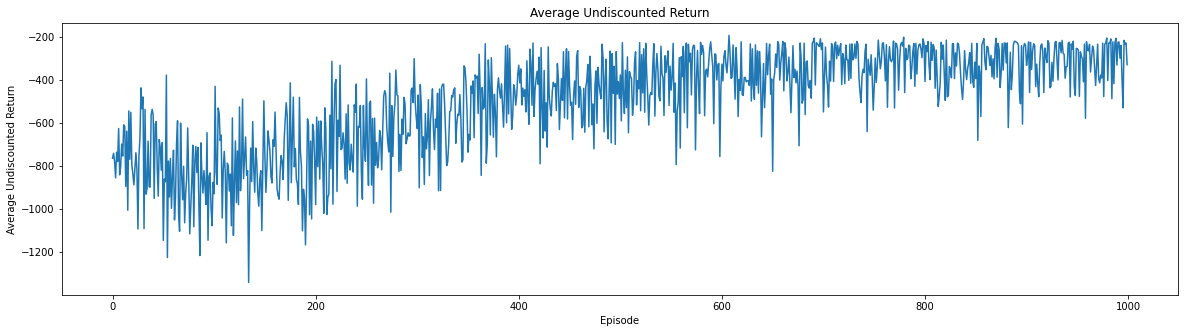

In [ ]:
# Plot the average undiscounted return across the 10 different runs with respect to the 
# number of episodes ( x-axis is the 1000 episodes, y-axis is the return for each episode)
# Compute the average undiscounted returns across all runs for each episode
avg_returns = np.mean(undiscounted_returns_list, axis=0)

# Plot the average returns with respect to the number of episodes
plt.plot(range(len(avg_returns)), avg_returns)
plt.xlabel('Episode')
plt.ylabel('Average Undiscounted Return')
plt.title('Average Undiscounted Return')
plt.show()


In [ ]:
# Visualize an episode, by generating and rendering an episode using
# one of the 10 learned approximate to verify its optimality.
POLICY_INDEX = 0
states = gen_episode(env, policy_list[POLICY_INDEX], render=True)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+


+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| :

In [ ]:
# What is the average undiscounted return for the last 100 episodes of the 10 runs
# (average over the 100 episodes, over 10 runs)? Why might this be smaller than you'd expect?

last_100_returns = avg_returns[-100:]
avg_last_100_returns = np.mean(last_100_returns)
print("Average undiscounted return for the last 100 episodes:", avg_last_100_returns)


Average undiscounted return for the last 100 episodes: -307.68100000000004


The average return is smaller than expected becasue the policy likely has not converged yet and would still be exploring different actions and states.

## 2.1.3: Monte Carlo prediction

In [ ]:
def monte_carlo_value_estimation(env, policy_b, policy_pi, num_episodes, gamma=0.99, sampling_method='ordinary'):
    V = np.zeros(env.observation_space.n)
    returns = np.zeros(env.observation_space.n)
    weights = np.zeros(env.observation_space.n)
    V_list = []

    for i in tqdm(range(num_episodes)):
        episode = gen_episode(env, policy_b)
        G = 0
        W = 1
        #V_episode = np.zeros(env.observation_space.n)

        for t in reversed(range(len(episode)-1)):
            state, action, reward = episode[t]
            G = gamma * G + reward

            if sampling_method == 'weighted':
              weights[state] += W
            elif sampling_method == 'ordinary':
              weights[state] += 1
            returns[state] += W * G
            
            V[state] = returns[state] / weights[state]
            #V_episode[state] = V[state]

            W *= policy_pi[state, action] / policy_b[state, action]
            if W == 0:
              break
        V_list.append(V.copy())

    return V_list

In [ ]:
def plot_many(experiments, label=None, color=None, title=""):
  mean_exp = np.mean(experiments, axis=0)
  std_exp = np.std(experiments, axis=0)
  plt.plot(mean_exp, color=color, label=label)
  plt.title(title)
  plt.xlabel("Episode")
  plt.ylabel("Value")
  plt.fill_between(range(len(experiments[0])), mean_exp+std_exp, mean_exp-std_exp, color=color, alpha=0.1)

Using ordinary Importance Sampling for the following graphs


100%|██████████| 1000/1000 [00:14<00:00, 68.03it/s]


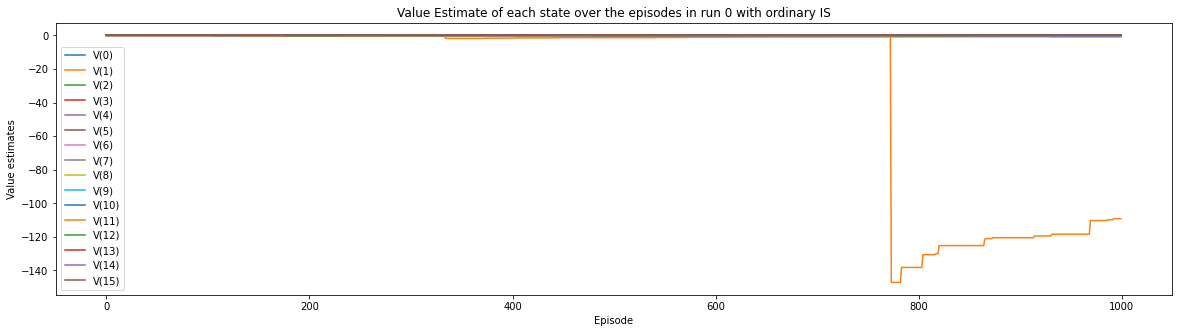

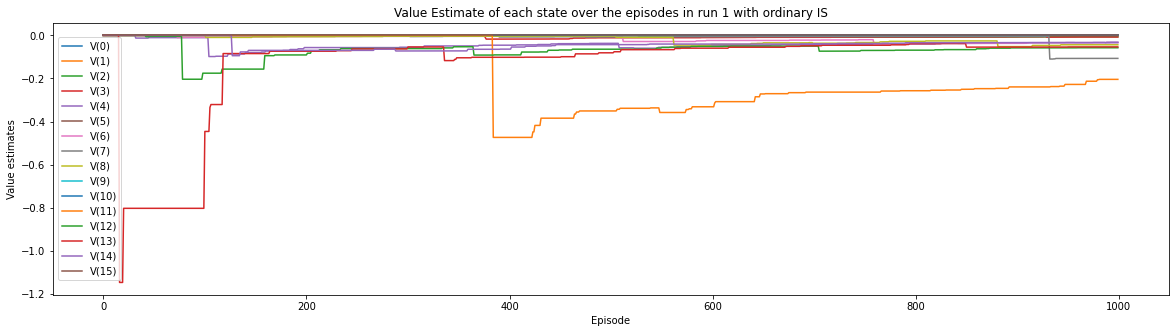

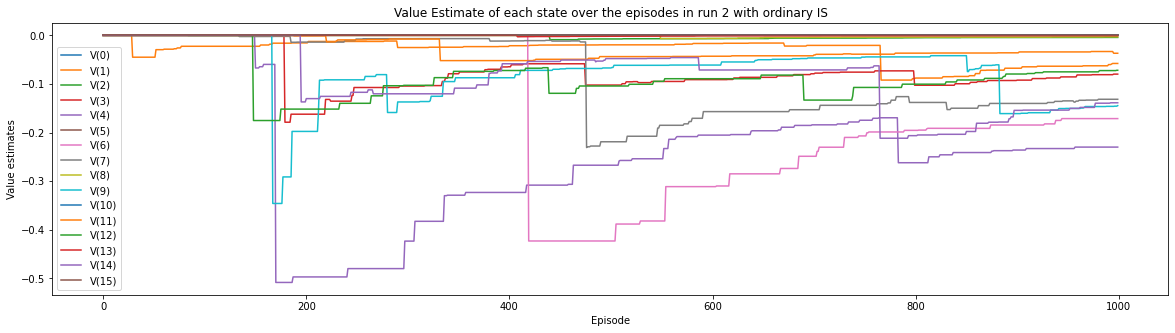

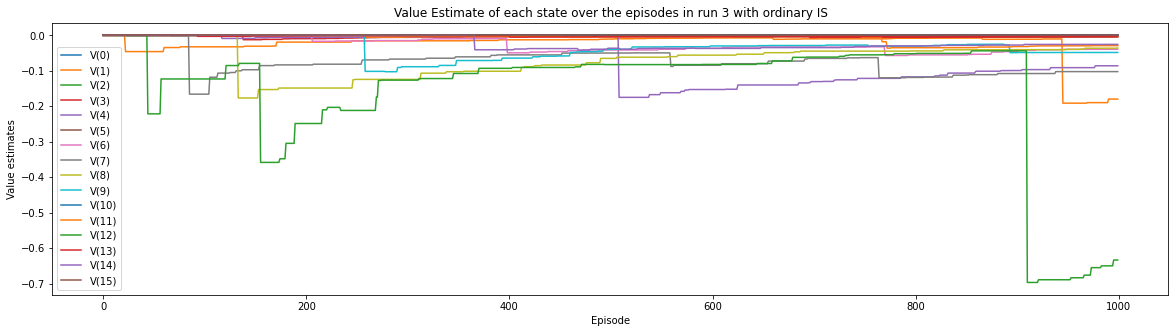

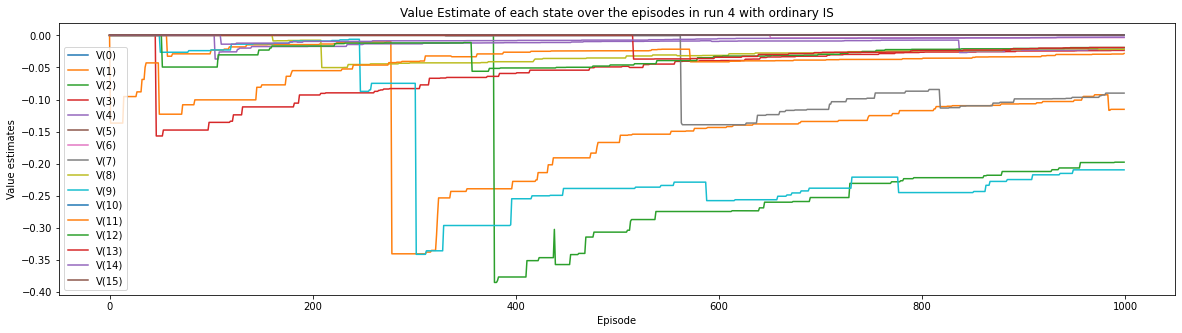

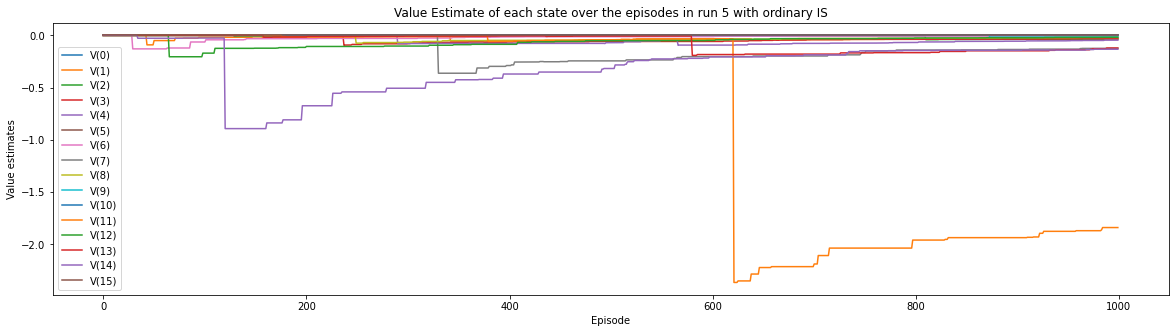

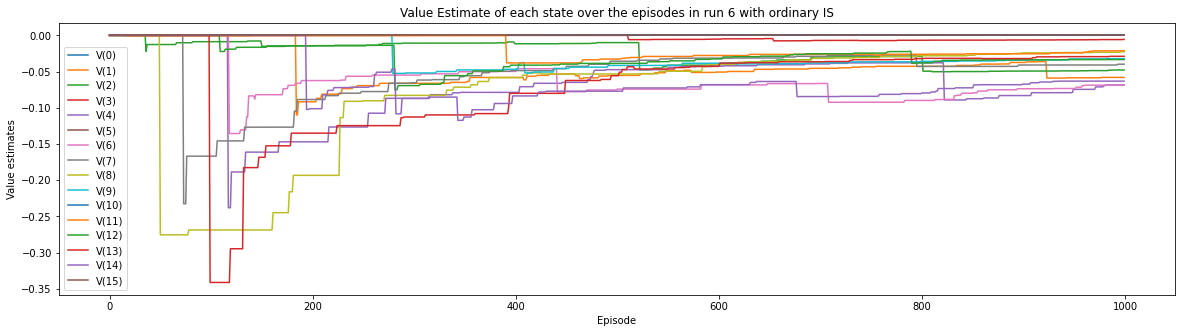

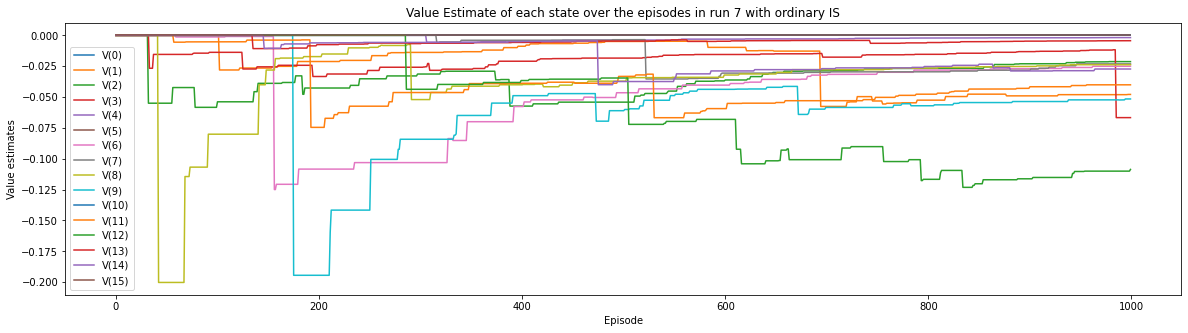

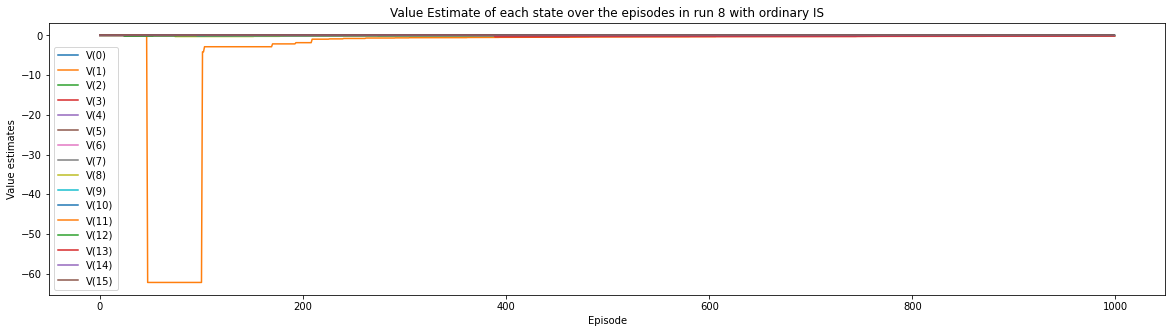

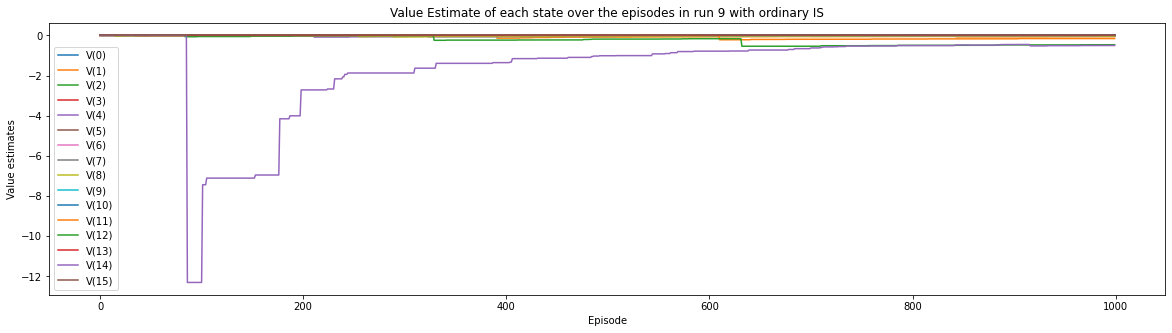

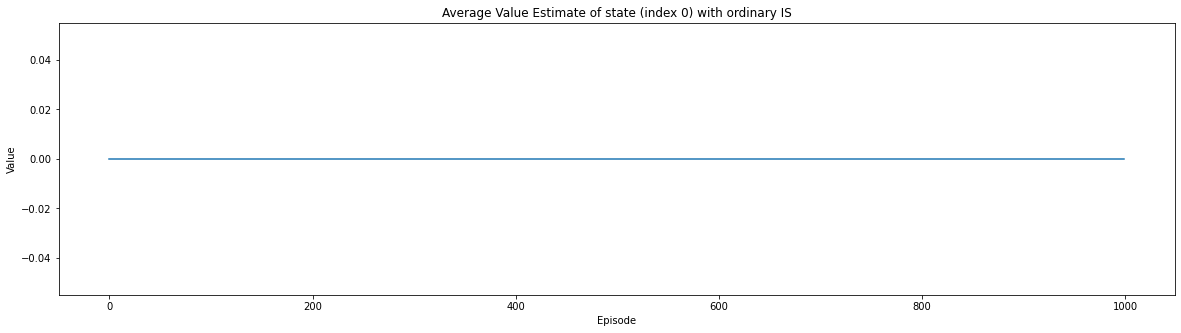

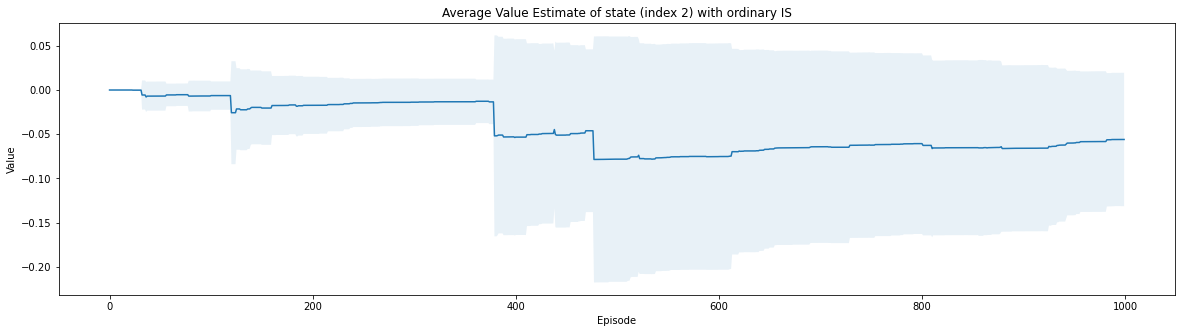

Using weighted Importance Sampling for the following graphs


100%|██████████| 1000/1000 [00:15<00:00, 66.07it/s]


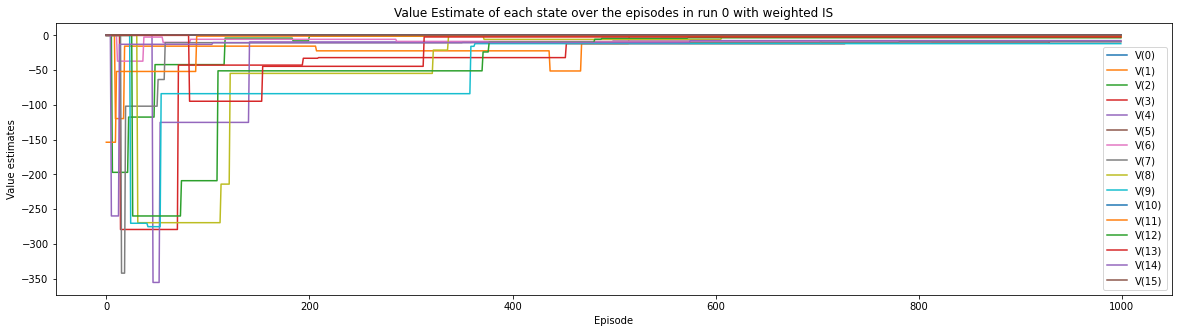

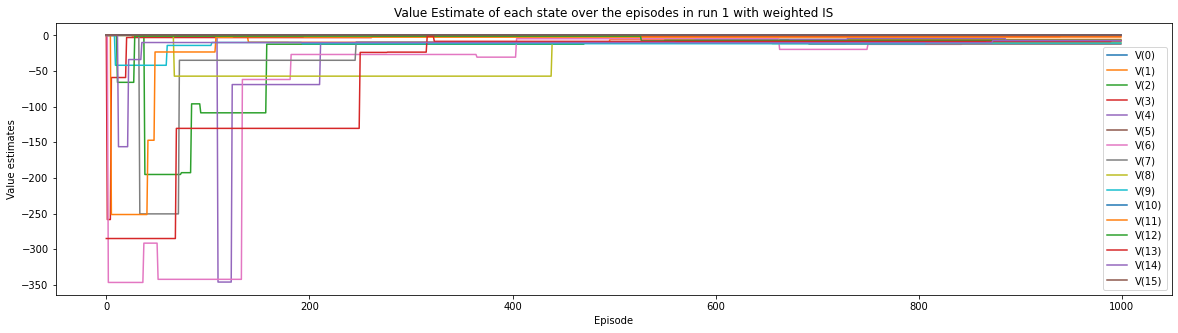

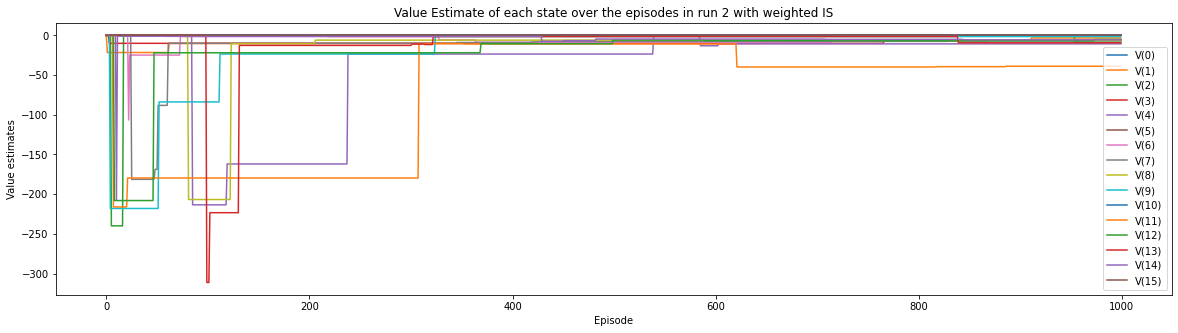

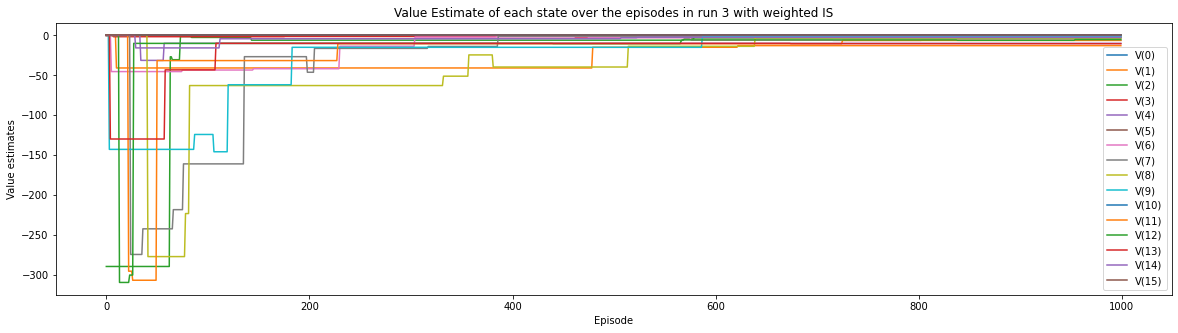

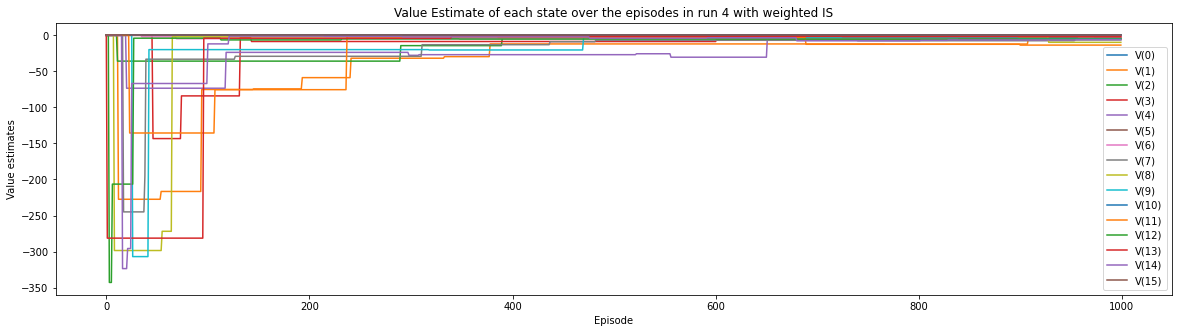

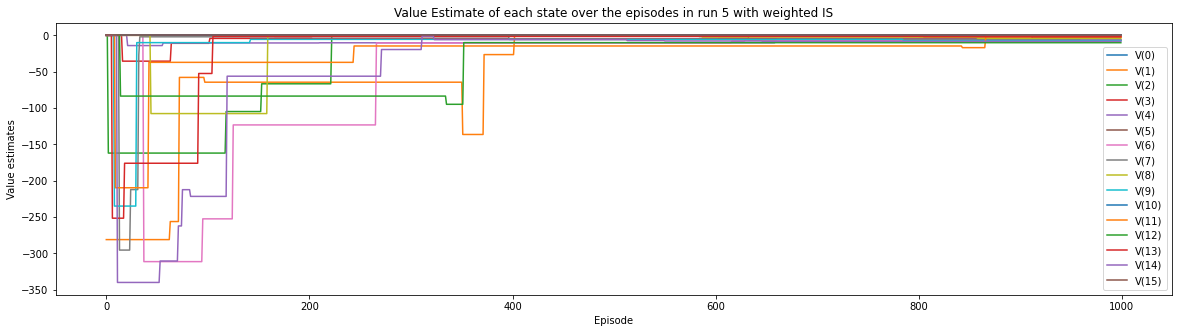

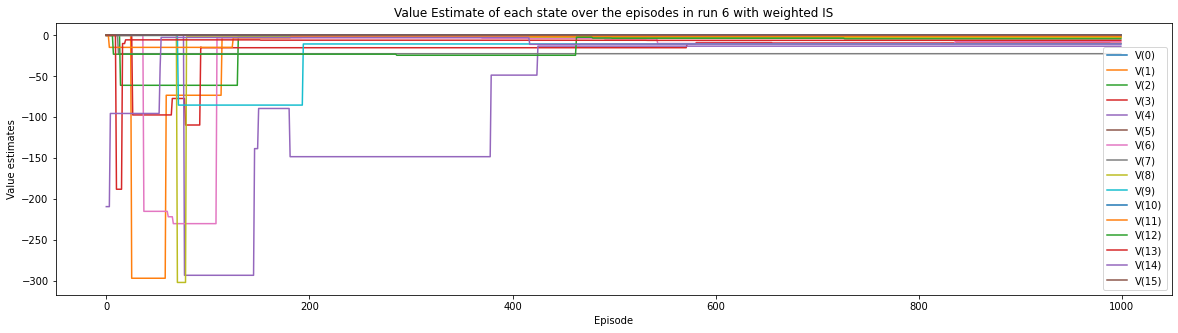

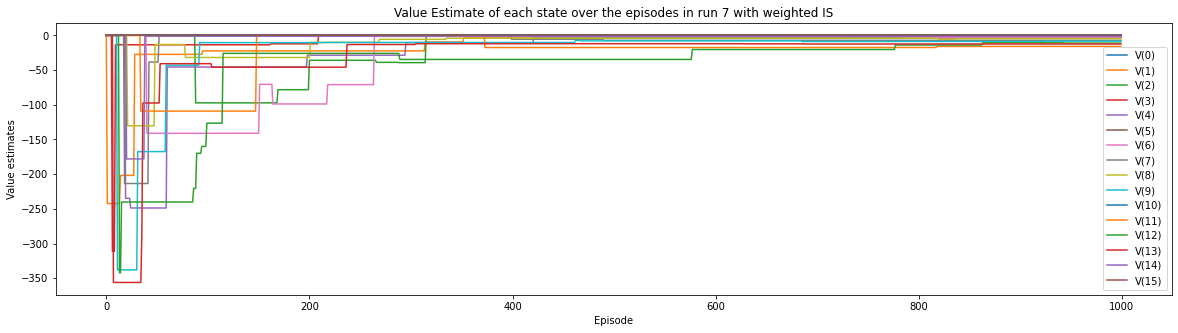

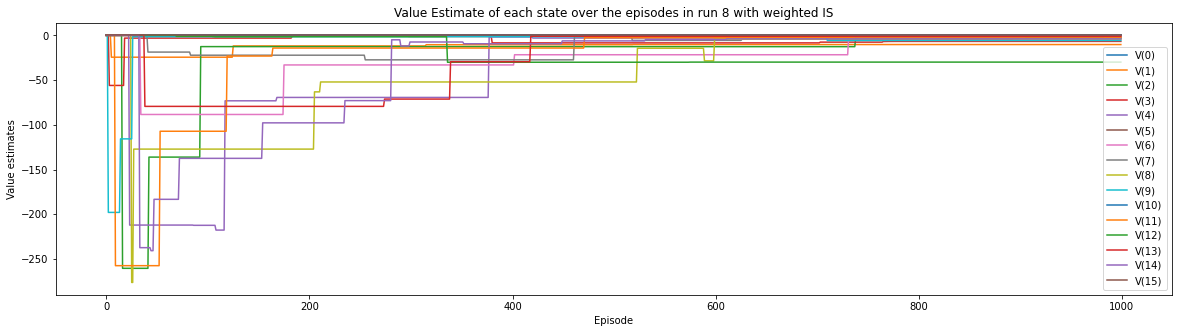

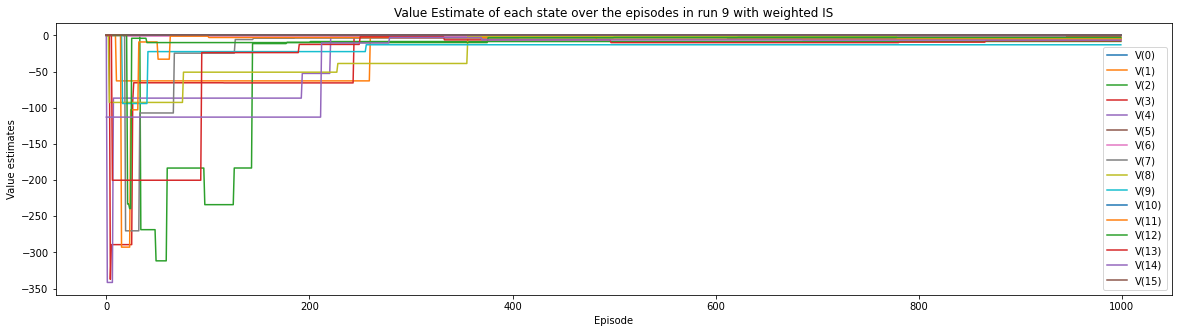

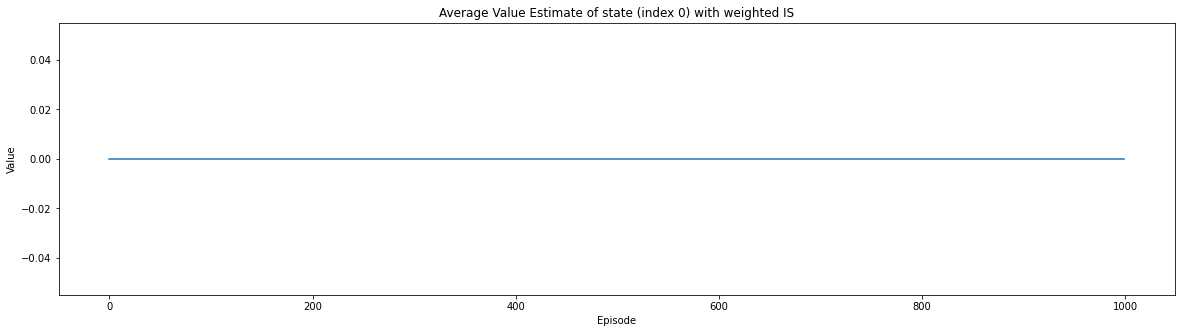

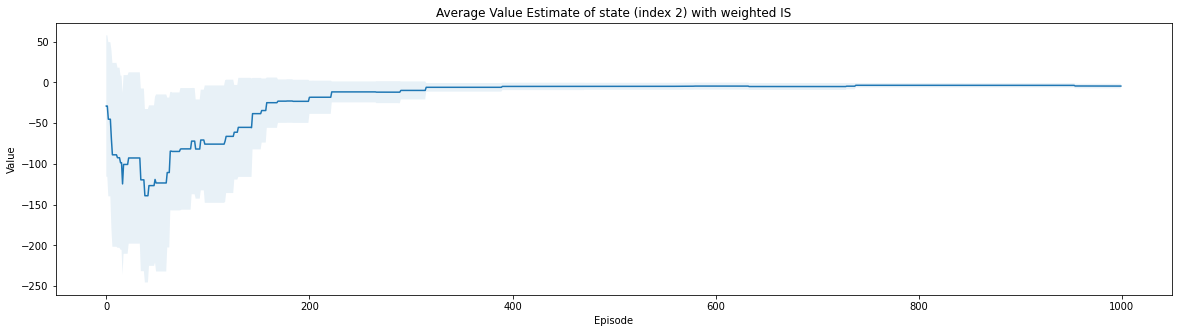

In [ ]:
policy_b = np.full((env.observation_space.n, env.action_space.n), 1/env.action_space.n)
policy_pi = policy_list[POLICY_INDEX]
MAX_PLOT_STATES=16 #env.observation_space.n
for method in ['ordinary', 'weighted']:
  print(f"Using {method} Importance Sampling for the following graphs")
  V_runs = []
  for run in range(10):
      V_list = monte_carlo_value_estimation(env, policy_b, policy_pi, 1000, sampling_method=method)
      V_runs.append(V_list)
  V_runs = np.array(V_runs)
  # Plot the Monte Carlo estimates of V(s) over the number of episodes
  for i in range(10):
      fig, ax = plt.subplots(1)
      for j in range(MAX_PLOT_STATES):
        ax.plot(V_runs[i, :, j], label='V({})'.format(j))
      ax.set_xlabel('Episode')
      ax.set_ylabel('Value estimates')
      plt.title(f"Value Estimate of each state over the episodes in run {i} with {method} IS")
      ax.legend()
  plt.show()
  # Plot the average value of state 0 over the episodes (averaged over runs)
  plot_many(V_runs[:,:,0], title=f"Average Value Estimate of state (index 0) with {method} IS")
  plt.show()

  # Plot the average value of state 2 over the episodes (averaged over runs)
  plot_many(V_runs[:,:,2], title=f"Average Value Estimate of state (index 2) with {method} IS")
  plt.show()

## 2.1.4: On-Policy Monte Carlo Prediction


In [ ]:
def monte_carlo_value_estimation_onpolicy(env, policy, num_episodes, gamma=0.99):
    V = np.zeros(env.observation_space.n)
    # returns = np.zeros(env.observation_space.n)
    returns = [[] for i in range(env.observation_space.n)]

    V_list = []
    for i in tqdm(range(num_episodes)):
      episode = gen_episode(env, policy)
      G = 0
      #V_episode = np.zeros(env.observation_space.n)

      for t in reversed(range(len(episode))):
          state, action, reward = episode[t]
          G = gamma * G + reward
          returns[state].append(G)
          V[state] = np.mean(returns[state])
          #V_episode[state] = V[state]
      V_list.append(V.copy())

    return V_list


In [ ]:
V_list = monte_carlo_value_estimation_onpolicy(env, policy_pi, 1000, gamma=0.99)
V_list = np.array(V_list)


100%|██████████| 1000/1000 [00:39<00:00, 25.13it/s]


Text(0.5, 1.0, 'Value Estimate of each state over the episodes')

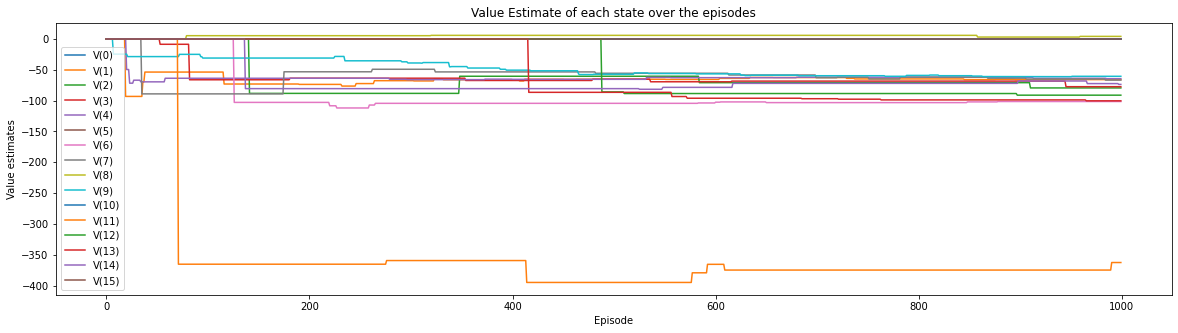

In [ ]:
fig, ax = plt.subplots(1)
for j in range(MAX_PLOT_STATES):
  ax.plot(V_list[:, j], label='V({})'.format(j))
ax.set_xlabel('Episode')
ax.set_ylabel('Value estimates')
ax.legend()
plt.title(f"Value Estimate of each state over the episodes")


## **2.2: Temporal Difference Control Methods**

In [ ]:
def epsilon_greedy_policy(epsilon, state, info, Q):
  possible_actions = np.arange(6) #np.where(info['action_mask'] == 1)[0]
  action_argmax = np.argmax(Q[state, possible_actions])
  action_max = possible_actions[action_argmax]

  if np.random.rand() >= epsilon:
      return action_max
  else:
      if len(possible_actions)==1:
        return action_max
      else:
        return np.random.choice(np.delete(possible_actions , action_argmax))

In [ ]:
def SARSA(env, num_episodes, epsilon=0.01, gamma=0.99 , step_size = 0.1, render = False):

  Q_list = []
  Q = np.zeros((env.observation_space.n , env.action_space.n)) 
  undiscounted_returns = []

  for i in tqdm(range(num_episodes)): 
    undiscounted_return = 0
    state , info = env.reset()  

    action = epsilon_greedy_policy(epsilon, state, info, Q)

    while True:
      if render:
        env.render()

      next_state, reward, done, truncated, info = env.step(action)
      next_action = epsilon_greedy_policy(epsilon, next_state, info, Q)
      undiscounted_return += reward

      Q[state , action] = Q[state,action] + step_size*(reward + gamma*Q[next_state,next_action] - Q[state,action])

      state = next_state 
      action = next_action

      if done or truncated:
        break
      
    Q_list.append(Q.copy())
    undiscounted_returns.append(undiscounted_return)
    
  return Q_list , undiscounted_returns

In [ ]:
# Training
SARSA_total_undiscounted_returns = []

for i in range(10):
  np.random.seed(i)
  SARSA_Q_list , SARSA_undiscounted_returns = SARSA(env, num_episodes = 1000, epsilon = 0.01, gamma=0.99 , step_size = 0.1 , render = False)
  SARSA_total_undiscounted_returns.append(SARSA_undiscounted_returns)

100%|██████████| 1000/1000 [00:02<00:00, 340.46it/s]


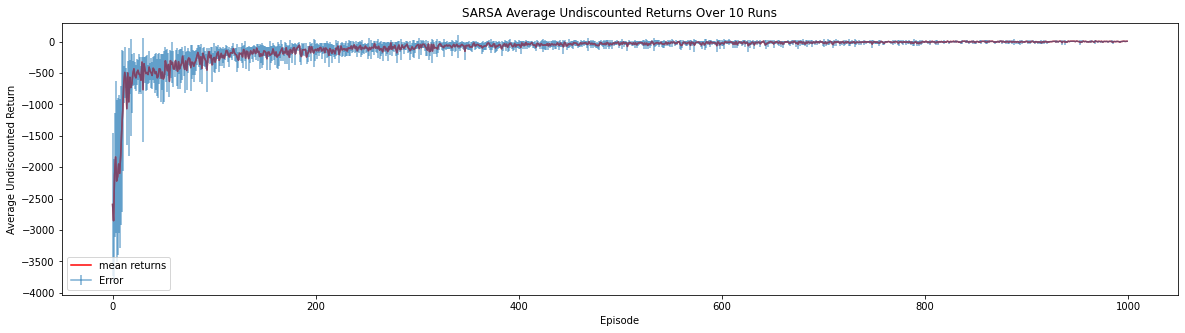

In [ ]:
SARSA_avg_returns = np.mean(np.array(SARSA_total_undiscounted_returns), axis=0)
# SARSA_avg_returns_init = np.array(SARSA_total_undiscounted_returns)[-1]
SARSA_std_returns = np.std(np.array(SARSA_total_undiscounted_returns), axis=0)

# Plot the average returns with respect to the number of episodes

plt.errorbar(range(len(SARSA_avg_returns)), SARSA_avg_returns , yerr = SARSA_std_returns, alpha = 0.6 , label = 'Error')
plt.plot(range(len(SARSA_avg_returns)) , SARSA_avg_returns , label = 'mean returns' , color = 'red')
# plt.plot(range(len(SARSA_avg_returns_init)) , SARSA_avg_returns_init , label = 'mean returns init' , color = 'black')
plt.legend()
plt.xlabel('Episode')
plt.ylabel('Average Undiscounted Return')
plt.title('SARSA Average Undiscounted Returns Over 10 Runs')
plt.show()

In [ ]:
def generate_greedy_episode(env, epsilon, Q, render=True):
  state , info = env.reset()
  #if state >= 404:
    #print("reset 404")
  total_reward = 0

  while True:
    if render:
      print(env.render())

    action = epsilon_greedy_policy(epsilon, state, info, Q)
    next_state, reward, done, truncated, info = env.step(action)

    state = next_state
    total_reward += reward 

    if done:
      return 0, total_reward
    elif truncated:
      return 1, total_reward

In [ ]:
generate_greedy_episode(env, 0.01, SARSA_Q_list[-1], True)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+


+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
|_| : | : |
|Y| : |B: |
+---------+
  (North)

+---------+
|R: | : :G|
| : | : : |
|_: : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)

+---------+
|R: | : :G|
| : | : : |
| :_: : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)

+---------+
|R: | : :G|
| : | : : |
| : :_: : |
| | : | : |
|Y| : |B: |
+---------+
  (East)

+---------+
|R: | : :G|
| : |_: : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)

+---------+
|R: | : :G|
| : | :_: |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)

+---------+
|R: | : :G|
| : | : :_|
| : : : : |
| | : | : |
|

(0, 9)

Text(0.5, 1.0, 'Action Value Estimate of each state over the episodes')

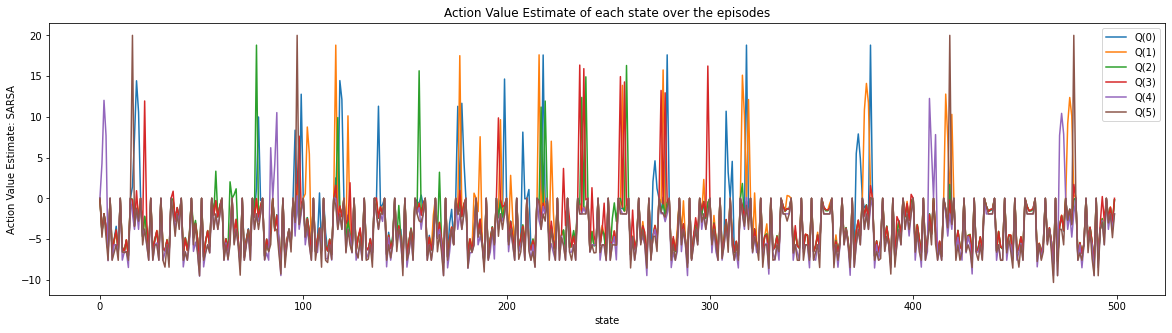

In [ ]:
# plotting the results
fig, ax = plt.subplots(1)
Q_arr = np.array(SARSA_Q_list)


for j in range(env.action_space.n):
  ax.plot(Q_arr[999,:,j], label='Q({})'.format(j))
ax.set_xlabel('state')
ax.set_ylabel('Action Value Estimate: SARSA')
ax.legend()
plt.title(f"Action Value Estimate of each state over the episodes")


### **Q - Learning :**

In [ ]:
def QLearning(env, num_episodes, epsilon=0.02, gamma=0.99 , step_size = 0.1, render = False):

  Q_list = []
  Q = np.zeros((env.observation_space.n , env.action_space.n)) 
  undiscounted_returns = []

  for i in tqdm(range(num_episodes)): 
    undiscounted_return = 0
    state , info = env.reset()  

    while True:
      if render:
        env.render()

      action = epsilon_greedy_policy(epsilon, state, info, Q)
      next_state, reward, done, truncated, info = env.step(action)
      undiscounted_return += reward

      greedy_action = epsilon_greedy_policy(0, next_state, info, Q)
      Q[state , action] = Q[state,action] + step_size*(reward + gamma*Q[next_state,greedy_action] - Q[state,action])
      state = next_state

      if done or truncated:
        break
      
    Q_list.append(Q)
    undiscounted_returns.append(undiscounted_return)
    
  return Q_list , undiscounted_returns

In [ ]:
# Training
QL_total_undiscounted_returns = []

for i in range(10):
  np.random.seed(i)
  QL_Q_list , QL_undiscounted_returns = QLearning(env, num_episodes = 1000, epsilon = 0.02, gamma=0.99 , step_size = 0.1 , render = False)
  QL_total_undiscounted_returns.append(QL_undiscounted_returns)

100%|██████████| 1000/1000 [00:03<00:00, 303.34it/s]


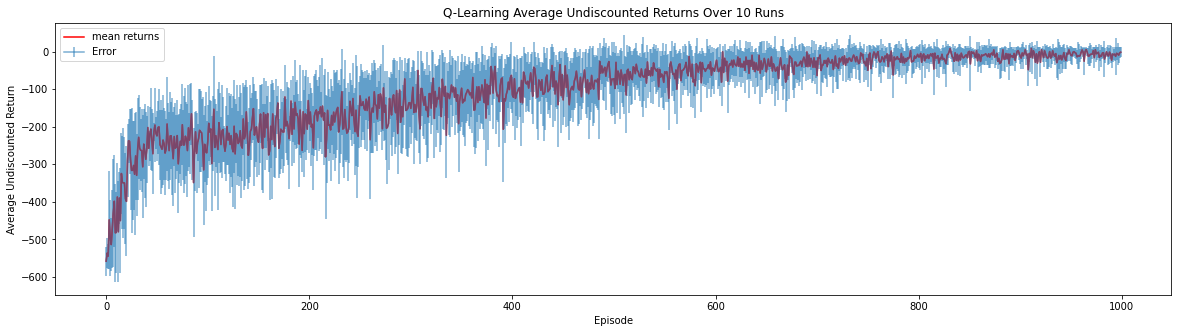

In [ ]:
QL_avg_returns = np.mean(np.array(QL_total_undiscounted_returns), axis=0)
QL_std_returns = np.std(np.array(QL_total_undiscounted_returns), axis=0)

# Plot the average returns with respect to the number of episodes

plt.errorbar(range(len(QL_avg_returns)), QL_avg_returns , yerr = QL_std_returns, alpha = 0.6 , label = 'Error')
plt.plot(range(len(QL_avg_returns)) , QL_avg_returns , label = 'mean returns' , color = 'red')
plt.legend()
plt.xlabel('Episode')
plt.ylabel('Average Undiscounted Return')
plt.title('Q-Learning Average Undiscounted Returns Over 10 Runs')
plt.show()

In [ ]:
generate_greedy_episode(env, 0, QL_Q_list[-1], True)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+


+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
|_| : | : |
|Y| : |B: |
+---------+
  (North)

+---------+
|R: | : :G|
| : | : : |
|_: : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)

+---------+
|R: | : :G|
| : | : : |
| :_: : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)

+---------+
|R: | : :G|
| : | : : |
| : :_: : |
| | : | : |
|Y| : |B: |
+---------+
  (East)

+---------+
|R: | : :G|
| : | : : |
| : : :_: |
| | : | : |
|Y| : |B: |
+---------+
  (East)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : |_: |
|Y| : |B: |
+---------+
  (South)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)



(0, 12)

# **2.2.3:** Performance comparison


The major differences betwen Monte-Carlo and TD learning is the rate of convergence to the optimal policy. MC is guaranteed to converge to the optimal solution with high probability but has a slower convergence rate compared to TD methods. TD methods, on the other hand, have a faster convergence rate and require less data to reach the optimal solution, so TD methods are more sample efficient.

In terms of variance, monte carlo suffers from high variance and low bias due to the randomness of exploration which makes the learning process more challenging.On the other hand, TD methods, have a lower variance and a higher bias as they use bootstrapping which yields to a more stable learning process. 


Finally, MC methods must wait until the end of the episode before the return is known whereas TD can learn online and efter each timestep in an episode. Therefore on the long run, Monte Carlo should perform better on episodic tasks whereas TD methods should perform better on continuous tasks. 

In [ ]:
%%shell
jupyter nbconvert --to html "MIE567_Project_2_Group_4.ipynb"

[NbConvertApp] Converting notebook MIE567_Project_2_Group_4.ipynb to html
[NbConvertApp] Writing 2346573 bytes to MIE567_Project_2_Group_4.html
